# 11-experiment-three-cogsci

## Integrity

In [1]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

### Reading Data

In [6]:
GROUPS = 2
QUESTIONS = 5
JUDGMENTS = 6
SCORE_THRESHOLD = 240.9

FILE_NAMES = [
    'data/raw.json',
]

master_responses = []
for name in FILE_NAMES:
    with open(name) as file:
        master_responses.extend(json.loads(line) for line in file if line)

In [7]:
def _get_group(score):
    if score < SCORE_THRESHOLD:
        return 0
    return 1

### Parsing Data

In [19]:
data = {
    'id': [],
    'consent': [],
    'attention': []
}

for g_num in range(GROUPS):
    for q_num in range(QUESTIONS):
        data['g{}_q{}_score'.format(g_num, q_num)] = []
        data['g{}_q{}_index'.format(g_num, q_num)] = []
        for j_num in range(JUDGMENTS):
            data['g{}_q{}_j{}'.format(g_num, q_num, j_num)] = []

{'participantID': 'sana26r21r9md90gqj3o7fm1rm4rpw2p',
 'judgmentIndices': [5, 1, 3, 2, 4, 0],
 'questionScores': [24046, 36, 25, 24059, 24047, 21, 24032, 13, 24039, 30],
 'questionIndices': [15, 2, 37, 30, 27, 20, 33, 23, 40, 0],
 'responseType': 'finish',
 'internal_node_id': '0.0-3.0',
 'time_elapsed': 142538,
 'trial_index': 7,
 'trial_type': 'survey-likert',
 'responses': '{"Q0":"4","Q1":"1","Q2":"0","Q3":"4","Q4":"4","Q5":"5","Q6":"6"}',
 'rt': 21523}

In [20]:
ANSWER_KEYS = ('Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5')

for person in master_responses:
    # Grab data & ID
    person_data = person['data']  
    data['id'].append(person_data[0]['participantID'])
    
    # Fill in question labels
    question_scores = person_data[0]['questionScores']
    question_indices = person_data[0]['questionIndices']
    
    counters = [0, 0]
    question_labels = []
    for score in question_scores:
        g_num = _get_group(score)
        question_labels.append('g{}_q{}'.format(g_num, counters[g_num]))
        counters[g_num] += 1
    
    for q_label, score in zip(question_labels, question_scores):
        data['{}_score'.format(q_label)].append(score)
    for q_label, index in zip(question_labels, question_indices):
        data['{}_index'.format(q_label)].append(index)
    
    # Get consent response
    consent_answer = json.loads(person_data[0]['responses'])
    consent_value = int(consent_answer['Q0'].startswith('I consent'))
    data['consent'].append(consent_value)

    # Fill in judgments
    judgment_indices = person_data[0]['judgmentIndices']
    
    for q_label, likert_index in zip(question_labels, range(2, 14)):
        answer = json.loads(person_data[likert_index]['responses'])
        for j_label, key in zip(judgment_indices, ANSWER_KEYS):
            rating = int(answer[key])
            data['{}_j{}'.format(q_label, j_label)].append(rating)

    # Attention check
    attention_answer = json.loads(person_data[7]['responses'])
    attention_value = int(attention_answer['Q6'] == '6')
    data['attention'].append(attention_value)

### Reading Responses into Data

In [21]:
data = pd.DataFrame(data)
sample_size = len(data)
data.head()

,id,consent,attention,g0_q0_score,g0_q0_index,g0_q0_j0,g0_q0_j1,g0_q0_j2,g0_q0_j3,g0_q0_j4,...,g1_q3_j4,g1_q3_j5,g1_q4_score,g1_q4_index,g1_q4_j0,g1_q4_j1,g1_q4_j2,g1_q4_j3,g1_q4_j4,g1_q4_j5
0,sana26r21r9md90gqj3o7fm1rm4rpw2p,1,1,36,2,4,3,5,0,5,...,1,2,24039,40,3,2,4,5,1,5
1,68d2brqo4tuf7kstwx0evwcuu5hqf9o2,1,1,30,10,2,2,3,2,2,...,3,3,24051,0,1,3,1,1,1,1
2,rxt9ompoqypdk5v67wmwpseu29te3s08,1,1,14,32,6,2,5,2,3,...,5,5,24047,23,2,0,1,6,6,1
3,e4zr4k2wtn02qngsjapkp4w911s169qu,1,0,15,45,6,0,4,0,6,...,6,6,24051,21,6,6,0,3,6,0
4,wul66ydj8kvrksvrb3u57s0eap457scs,1,1,24,41,5,0,3,4,6,...,6,4,24032,42,2,0,4,6,5,4


In [22]:
print(len(data), data.size)
data = data[data.consent == 1]
print(len(data), data.size)
data = data[data.attention == 1]
print(len(data), data.size)

print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

98 8134
98 8134
91 7553
Inclusion: 92.86% 


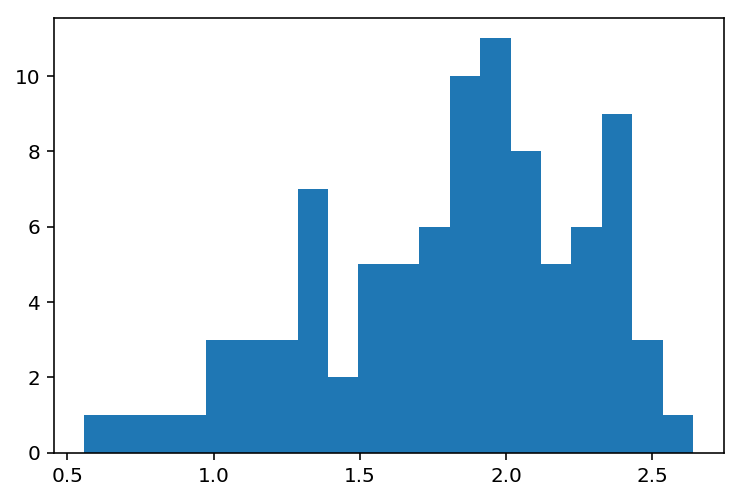

[[4 3 3 4 4 3 4 3 4 4 3 4 4 4 4 3 3 3 4 3 4 4 3 4 3 4 4 3 3 4 4 4 4 3 3 4
  4 3 4 2 5 4 3 4 4 4 3 4 4 3 4 4 3 4 3 4 4 3 3 4]]


In [34]:
judgments = []
for g_num in range(GROUPS):
    for q_num in range(QUESTIONS):
        for j_num in range(JUDGMENTS):
            judgments.append('g{}_q{}_j{}'.format(g_num, q_num, j_num))
scores = data[judgments]
data['j_mean'] = scores.mean(axis=1)
data['j_std'] =scores.std(axis=1)

plt.hist(data['j_std'], bins=20)
plt.show()

index = np.argmin(data['j_std'])
print(scores.loc[[index]].values)

In [36]:
print(len(data), data.size)
data = data[data.j_std > 0.75]
index = np.argmin(data['j_std'])
print(scores.loc[[index]].values)
print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

89 7565
[[2 2 2 2 2 2 2 2 3 3 3 3 2 5 2 2 2 2 3 3 2 2 2 2 4 1 2 4 2 4 2 3 2 2 2 2
  4 2 3 3 3 3 4 1 4 3 3 4 2 3 2 2 2 2 2 1 2 2 2 2]]
Inclusion: 90.82% 


### Saving Data

In [37]:
data.to_pickle('data/responses.pkl')